# SARDI Capture Evaluation

First a qualitative comparison of rgb image, averaged 'ground truth', the original image, and the classified result.

In [248]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import cv2
import os

from spectral import *

from os.path import exists

from sklearn.decomposition import PCA

from skimage.segmentation import slic, mark_boundaries

from sklearn.cluster import KMeans

In [326]:
path = "processed-data/sardi-capture-final/final/reflectance/2023_03_28/food_and_waste/"
path = "processed-data/sardi-capture-final/final/reflectance/2023_03_28/just_waste/"

dir_cont = os.listdir(path)

data_cubes = [cont for cont in dir_cont if '.nc' in cont]

data_cubes = sorted(data_cubes)

cubes = data_cubes

print(cubes)

['2023_03_28-01_45_56.nc', '2023_03_28-01_48_52.nc', '2023_03_28-01_51_30.nc', '2023_03_28-01_54_05.nc', '2023_03_28-01_56_37.nc', '2023_03_28-01_58_54.nc']


In [456]:
iteration='2023_03_28-01_58_54'

## Loading Data

Here I'm going to use my pre-processed files containing reflectance values.

Given the fact that OpenHSI saves them in NetCDF format I'm using the `netCDF4` library to load them.

I'm also transposing the data array into a more comment layout.

In [457]:
fn = path + iteration + ".nc"
fn_rad = fn.replace('reflectance','radiance')

In [458]:
# Load data
ds = nc.Dataset(fn)
ds_rad = nc.Dataset(fn_rad)

In [459]:
# extract the datacube from the dataset
dc = np.array(ds['datacube'])

In [460]:
# Data needs to be x, y, bands instead of bands, x, y.
data = dc.transpose(1,2,0)

In [461]:
# limit data to area of interest?
# data = data[:430,:930, :]

In [462]:
# transform into a line of pixels for PCA
X = data.copy().reshape(data.shape[0]*data.shape[1],data.shape[2])

In [463]:
print(X.shape)

(395100, 131)


## Useful Functions

In [464]:
def process_into_rgb(loc_ds):
    """
    Processes a given dataset into an rgb image for display
    """
    loc_dc = np.array(loc_ds['datacube']).transpose(1,2,0)
    loc_binned_wavelengths = np.array(loc_ds['wavelength'])

    red_nm = 640
    green_nm = 550
    blue_nm = 470
    
    rgb = np.zeros( (*loc_dc.shape[:2],3), dtype=np.float32)
    rgb[...,0] = loc_dc[:,:,np.argmin(np.abs(loc_binned_wavelengths-red_nm))]
    rgb[...,1] = loc_dc[:,:,np.argmin(np.abs(loc_binned_wavelengths-green_nm))]
    rgb[...,2] = loc_dc[:,:,np.argmin(np.abs(loc_binned_wavelengths-blue_nm))]
    
    rgb = np.minimum(np.maximum(rgb, 0), 1)

    rgb *= 255
    rgb = rgb.astype(np.uint8)
    
    return rgb

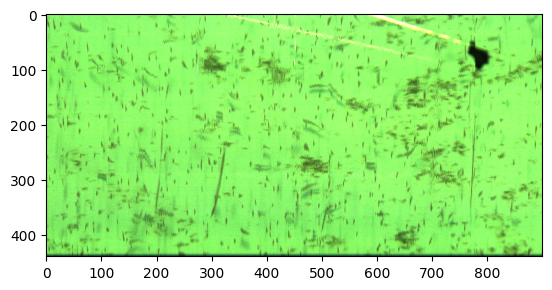

In [465]:
plt.imshow(process_into_rgb(ds_rad))

## Reducing Dimentionality

I'm just going to perform a simple PCA here to reduce the dimentionality of the image. I should be able to reduce the number of bands without distorting the spacial data and then apply the segmentation later to the original data, or an RGB representation, if I wish.

The first section of code is redundant and only there for sanity checking and illustrative purposes

### PCA

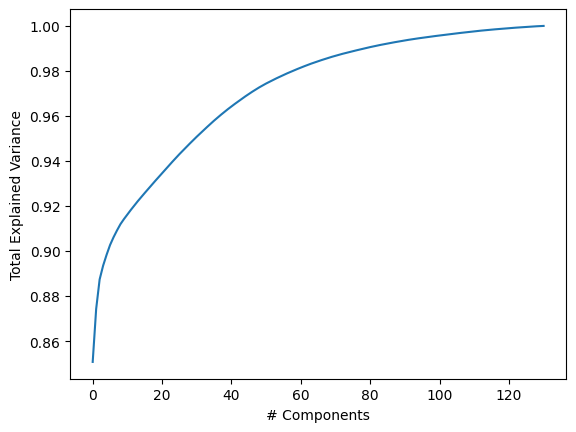

In [466]:
run = True
if run:
    pca = PCA()

    # fit my data, and transform
    pcX = pca.fit_transform(X)

    # graph the variance of each component (should give a good idea about the number of components to use).
    ev = pca.explained_variance_ratio_
    cumulativeVar = np.cumsum(ev)
    
    plt.plot(cumulativeVar)
    plt.xlabel('# Components')
    plt.ylabel('Total Explained Variance')
    plt.savefig(fn.split('.')[0] + '_pca.png')
    plt.show()

Now to actually perform the PCA.

In [467]:
# pick number of components that seems reasonable.
nComp = 30 # between 85-90% of the variance
pca = PCA(n_components=nComp)
pca.fit(X)
pcX = pca.transform(X)

In [468]:
# check the new dimensions
print(pcX.shape)

(395100, 30)


In [469]:
# reformat the image into the original shape
image_pca = pcX.reshape(data.shape[0], data.shape[1], pcX.shape[1])
print(image_pca.shape)

(439, 900, 30)


In [470]:
# let's have a look at the reduced image, if using 3 components
if image_pca.shape[2] == 3:
    plt.imshow(image_pca, 'gray')

## K-means elbow method to determine optimal n_clusters

/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in

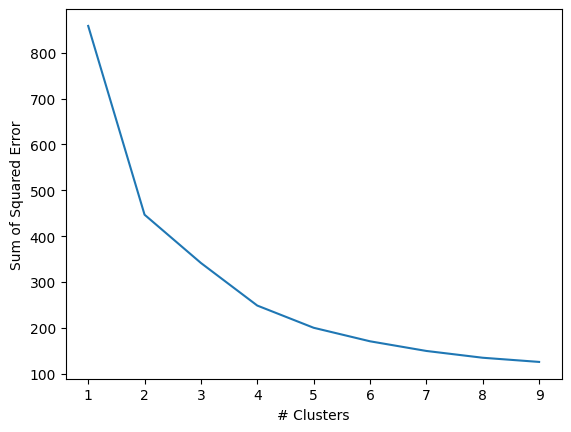

In [471]:
# Only running this once to prove a point, it takes too long.
run = True
if run:
    inertia = {}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k).fit(pcX)
        inertia[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(inertia.keys()), list(inertia.values()))
    plt.xlabel("# Clusters")
    plt.ylabel("Sum of Squared Error")
    plt.savefig(fn.split('.')[0] + '_kmeans.png')
    plt.show()

## Classification

In [472]:
# create our classifier
k_means = KMeans(n_clusters=5) # based on elbow method above, going to stick to this number

In [473]:
# classify
k_fit = k_means.fit(pcX)

/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [474]:
# capture clusers and labels
x_labels = k_means.labels_
x_cluster = x_labels.reshape(image_pca[:, :, 0].shape)

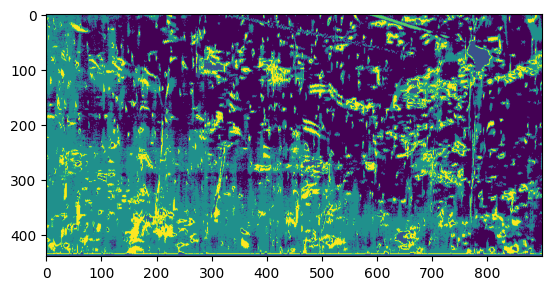

In [475]:
plt.imshow(x_cluster)
plt.imsave(fn.split('.')[0]+'_classification.png', x_cluster)
with open(fn.split('.')[0]+'_classification.pkl', 'wb') as out_file:
    pickle.dump(x_cluster, out_file)

# Extract Target Clustering

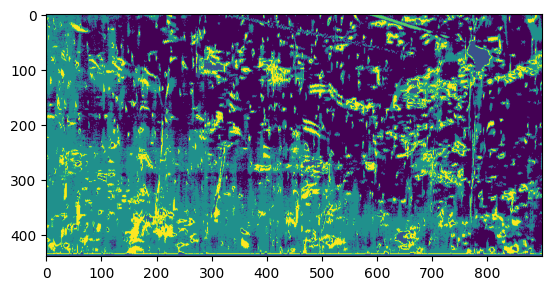

In [476]:
# read saved classification
with open(fn.split('.')[0]+'_classification.pkl', 'rb') as in_file:
    x_cluster = pickle.load(in_file)
    plt.imshow(x_cluster)

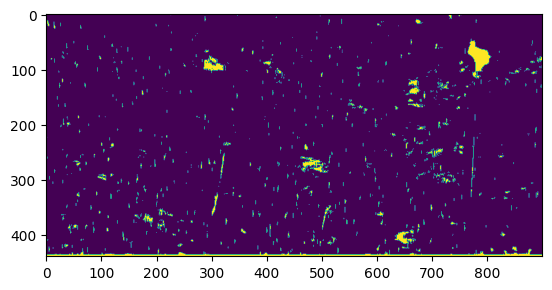

In [481]:
classified_waste = x_cluster.copy()

target = 1
                
idx = classified_waste != target
neg_idx = classified_waste == target
            
classified_waste[idx] = 0
classified_waste[neg_idx] = 1
            
plt.imshow(classified_waste)

In [482]:
plt.imsave(fn.split('.')[0]+'_classification-waste.png', classified_waste)
with open(fn.split('.')[0]+'_classification-waste.pkl', 'wb') as out_file:
    pickle.dump(classified_waste, out_file)